# Lab assignment: dogs VS cats

<table><tr>
    <td><img src="img/doge.jpg" style="width:400px;height:400px;"></td>
    <td><img src="img/cat.jpg" style="width:400px;height:400px;"></td>
</tr></table>

In this assignment we will face an image classification problem, trying to tell apart images of dogs and images of cats. The final battle begins! And to do so we will use a Deep Learning approach.

## Guidelines

Throughout this notebook you will find empty cells that you will need to fill with your own code. Follow the instructions in the notebook and pay special attention to the following symbols.

<img src="img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
You will need to solve a question by writing your own code or answer in the cell immediately below or in a different file, as instructed.</font>

***

<img src="img/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
This is a hint or useful observation that can help you solve this assignment. You should pay attention to these hints to better understand the assignment.
</font>

***

<img src="img/pro.png" height="80" width="80" style="float: right;"/>

***
<font color=#259b4c>
This is an advanced exercise that can help you gain a deeper knowledge into the topic. Good luck!</font>

***

To avoid missing packages and compatibility issues you should run this notebook under one of the [recommended Deep Learning environment files](https://github.com/albarji/teaching-environments/tree/master/deeplearning).

The following code will embed any plots into the notebook instead of generating a new window:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

Lastly, if you need any help on the usage of a Python function you can place the writing cursor over its name and press Caps+Shift to produce a pop-out with related documentation. This will only work inside code cells. 

Let's go!

## Data processing

The images to use in this assignment are available [here](https://drive.google.com/open?id=105jGDrjEgxx2W2gYhFF8Mbf1J9qJeDPm). Download the data package and extract it into a folder in your computer.

Data is structured under two folders, *train* and *test*. You are only allowed to use the *test* data to measure the performance of your model **after** you have finished training. Both *train* and *test* folders contain one subfolder per class (*cats* and *dogs*).

The recommended way to load an image from disk is to use the *imread* function from the *scikit-image* library. For example:

In [2]:
from skimage.io import imread

image = imread("./img/sample.jpg")

This returns the image as 3-dimensional numpy matrix, containing the value of intensity of every pixel in each row, column and color channel.

In [3]:
image.shape

(499, 367, 3)

We can visualize the loaded image using

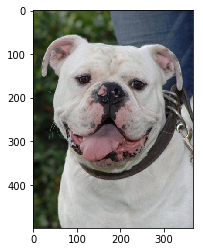

In [4]:
plt.imshow(image)

The dataset includes 20000 training images and 5000 test images, each image at a different resolution. Loading all this data at once requires too much memory, so we will need to **resize** each image to a smaller, common size as we load them from disk. We can do so by again making use of a *scikit-image* function. For example:

C:\Anaconda3\envs\deeplearning-labs\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


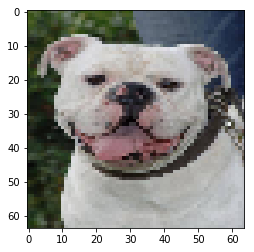

In [5]:
from skimage.transform import resize

size = 64
smallimage = resize(image, (64, 64, 3), mode="reflect")  # 64 x 64 pixels, 3 color channels
plt.imshow(smallimage)

<img src="img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
    
Perform the following tasks to prepare the data:
- Build a numpy array *X_train* containing one entry for each training image in the data. Each entry must contain the 3-dimensional matrix of pixels corresponding to an image. Make sure to scale down each image to a common size
- Normalize *X_train* so that pixels follow a distribution lying in the range [-0.5,0.5]
- Build a corresponding array *Y_train* with the class of each training image (0 for cats and 1 for dogs).
- Randomly shuffle the data. Make sure you shuffle both *X_train* and *Y_train* using the same permutation, so you don't lose track of the class of each training pattern.

- Repeat the whole procedure again to generate *X_test* and *Y_test* matrices for the test data.
</font>

***

<img src="img/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
- Take advantage of the *glob* package to generate the filename lists for the indoor and outdoor subfolders.
- Since you need to repeat the procedure both for training and test data, it would be useful to implement a function that performs all the data loading and transforming steps.
</font>

***

# Librerías
Se importan las librerías necesarias

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import math
import glob
import os
from skimage.io import imread
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import random
from functools import reduce # to run reduce tool from mapReduce.
import gzip # to compress files
import pickle # to save files -fitted models
from keras.utils import np_utils # to make continuos variables categorical ones
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Activation
from keras.layers.core import Dropout

Using TensorFlow backend.


In [7]:
random.seed(77)
np.random.seed(77)

<li>Función: Lectura de imágenes con escalado entre (-0.5,0.5)</li>

In [7]:
def file_load(dataset,animal,size,scaler_range):
    X,y = [],[]
    scaler= MinMaxScaler(feature_range= scaler_range)
    for file in glob.glob('./catsVSdogs/' + dataset + '/' + animal + '/*.jpg'):
        # get the X features
        image = imread(file)
        resizedImage= resize(image, size, mode="reflect")
        X.append(np.array([scaler.fit_transform(elem) for elem in resizedImage]))
        # get the y labels
        if animal == 'cats':
            y.append(0)
        elif animal == 'dogs':
            y.append(1)
        else:
            y.append(99)
    return zip(X,y)

<li>Función: Reordenar listas</li>

In [8]:
def sortList(x,positionList):
    return [x[pos] for pos in positionList]

<li>Función: Guardar fichero comprimido en local</li>

In [9]:
def compressedFileSave(pathName,fileName, variable):
    f = gzip.open(pathName+fileName+'.pkz', mode='wb', compresslevel=9)
    pickle.dump(variable, f, protocol=3)
    f.close()

<li>Función: Cargar fichero comprimido desde local</li>

In [10]:
def compressedFileLoad(pathName,fileName):
    f = gzip.open(pathName+fileName+'.pkz', mode='rb')
    aux = pickle.load(f)
    f.close()
    return aux

<li>Se obtiene un dictionario con las imágenes y su label, 0 o 1 según corresponda a <i>cat</i> o <i>dog</i>. Además, se escala al rango (-0.5,0.5)</li>

In [11]:
datasetList= ['train','test']
animalList= ['cats','dogs']
size= (64, 64, 3)
scaler_range= (-0.5,0.5)
cnd_dict={
    dataset:{
        animal:{
            'X': [elem[0] for elem in list(file_load(dataset,animal,size,scaler_range))],
            'y': [elem[1] for elem in list(file_load(dataset,animal,size,scaler_range))]
        }
        for animal in animalList
    } 
    for dataset in datasetList
}

<li>Guardado del diccionario.</li>

In [13]:
variable= cnd_dict
fileName= 'cnd_dict'
pathName= './notebook_files/'
compressedFileSave(pathName,fileName,variable)

<li>Carga del diccionario.</li>

In [14]:
fileName= 'cnd_dict'
pathName= './notebook_files/'
cnd_dict= compressedFileLoad(pathName,fileName)

<li>Se construye el training y testing data set y se realiza el shuffle a nivel indice entre <i>cat</i> y <i>dog</i>.</li>

In [26]:
X_train_orig, y_train_orig= reduce(lambda x,y: x+y, [cnd_dict['train'][animal]['X'] for animal in animalList]), reduce(lambda x,y: x+y, [cnd_dict['train'][animal]['y'] for animal in animalList])
train_index= list(range(len(X_train_orig)))
train_index_shff= train_index
random.shuffle(train_index_shff)
X_train,y_train= [sortList(elem,train_index_shff) for elem in [X_train_orig, y_train_orig]]
X_train,y_train= np.array(X_train),np.array(y_train)

In [31]:
X_test_orig, y_test_orign= reduce(lambda x,y: x+y, [cnd_dict['test'][animal]['X'] for animal in animalList]), reduce(lambda x,y: x+y, [cnd_dict['test'][animal]['y'] for animal in animalList])
X_test_orig, y_test_orig= reduce(lambda x,y: x+y, [cnd_dict['test'][animal]['X'] for animal in animalList]), reduce(lambda x,y: x+y, [cnd_dict['test'][animal]['y'] for animal in animalList])
test_index= list(range(len(X_test_orig)))
test_index_shff= test_index
random.shuffle(test_index_shff)
X_test,y_test= [sortList(elem,test_index_shff) for elem in [X_test_orig, y_test_orig]]
X_test,y_test= np.array(X_test),np.array(y_test)

If everything has been properly loaded both X_train and Y_train lists should have equal length, and the same should happen for the pair X_test and Y_test.

In [27]:
print("X_train size", len(X_train))
print("y_train size", len(y_train))
print("X_test size", len(X_test))
print("y_test size", len(y_test))

X_train size 6
y_train size 6
X_test size 6
y_test size 6


<li>Guardado de los data sets.</li>

In [28]:
variable_list= [X_train,y_train,X_test,y_test]
fileName_list= ['X_train','y_train','X_test','y_test']
pathName= './notebook_files/'
_=[compressedFileSave(pathName,fileName,variable) for fileName, variable in zip(fileName_list,variable_list)]

## Basic deep model

<img src="img/question.png" height="80" width="80" style="float: right;"/>

***
<font color=#ad3e26>
Create a deep network that achieves at least a 60% of accuracy in the test set. Make use of the layers you seem fit for problem. You cannot use the test data for fitting the network, but you can use it to check the final performance of different network architectures, and select the architecture performing best.</font>

***

<img src="img/exclamation.png" height="80" width="80" style="float: right;"/>

***
<font color=#2655ad>
    
If you are unable to attain the required 60% of accuracy, or your accuracy is too close to 100%, review the following checklist:
- Have you mixed training and test data?
- Have the values of the pixels been normalized?
- Have you compiled the model with a loss function appropriate for **binary** classification?
- Have you used ReLU units in the hidden layers? Have you used sigmoid or softmax layers in the output layer?

***

## Improving the network

<img src="img/pro.png" height="80" width="80" style="float: right;"/>

***

<font color=#259b4c>
    
You can further improve your results by applying one or more of the following strategies:
- Keep apart a portion of the training data as a **validation set**. Then use an <a href="https://keras.io/callbacks/#earlystopping">**EarlyStopping strategy**</a> to monitor the loss of these validation data, and stop when training when after a number of iterations such loss has not decreased.
- Make use of **metamodelling techniques** to select the best architecture parameters for the networks. You can use scikit-learn methods GridSearchCV or RandomSearchCV. You can do those by using the <a href="https://keras.io/scikit-learn-api/">KerasClassifier</a> wrapper. Even better, you can mix KerasClassifier with an advanced search method such as [BayesSearch](https://scikit-optimize.github.io/#skopt.BayesSearchCV), included in the [scikit-optimize](https://scikit-optimize.github.io/) library.
- Use **image augmentation techniques** to artifically create new training images. To do so, you can make use of <a href="https://keras.io/preprocessing/image/">ImageDataGenerator</a> in Keras.
- Make use of a pre-trained large network, building your network on top of it. You can find some examples in the [Keras Applications](https://keras.io/applications/) page.

If you correctly use these techniques you should be able to improve your model. With some effort it is possible to up to a 90% test accuracy. Try to do your best!</font>

***

In [28]:
####### INSERT YOUR CODE HERE

## Analyzing the results

<img src="img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Find and show some test images for which your model fails. Can you give an explanation for this behavior?</font>

***

In [29]:
####### INSERT YOUR CODE HERE

<img src="img/question.png" height="80" width="80" style="float: right;"/>

***

<font color=#ad3e26>
Write a small report summarizing the network choices you have tried, what worked and what didn't. What have you learned from this experience?</font>

***